Using cuda device to train
---  There is this folder!  ---
[0.1868183  0.18438691 0.18767768 0.19472977 0.20396329 0.21414624
 0.22436539 0.23398821 0.24260814 0.24998031 0.2559612  0.26046008
 0.26340399 0.26472069 0.2643475  0.26226161 0.25850383 0.25317361
 0.2464112  0.23839889 0.22938937 0.21974604 0.20997582 0.20074177
 0.19285231 0.18723413 0.18490362 0.18695056]


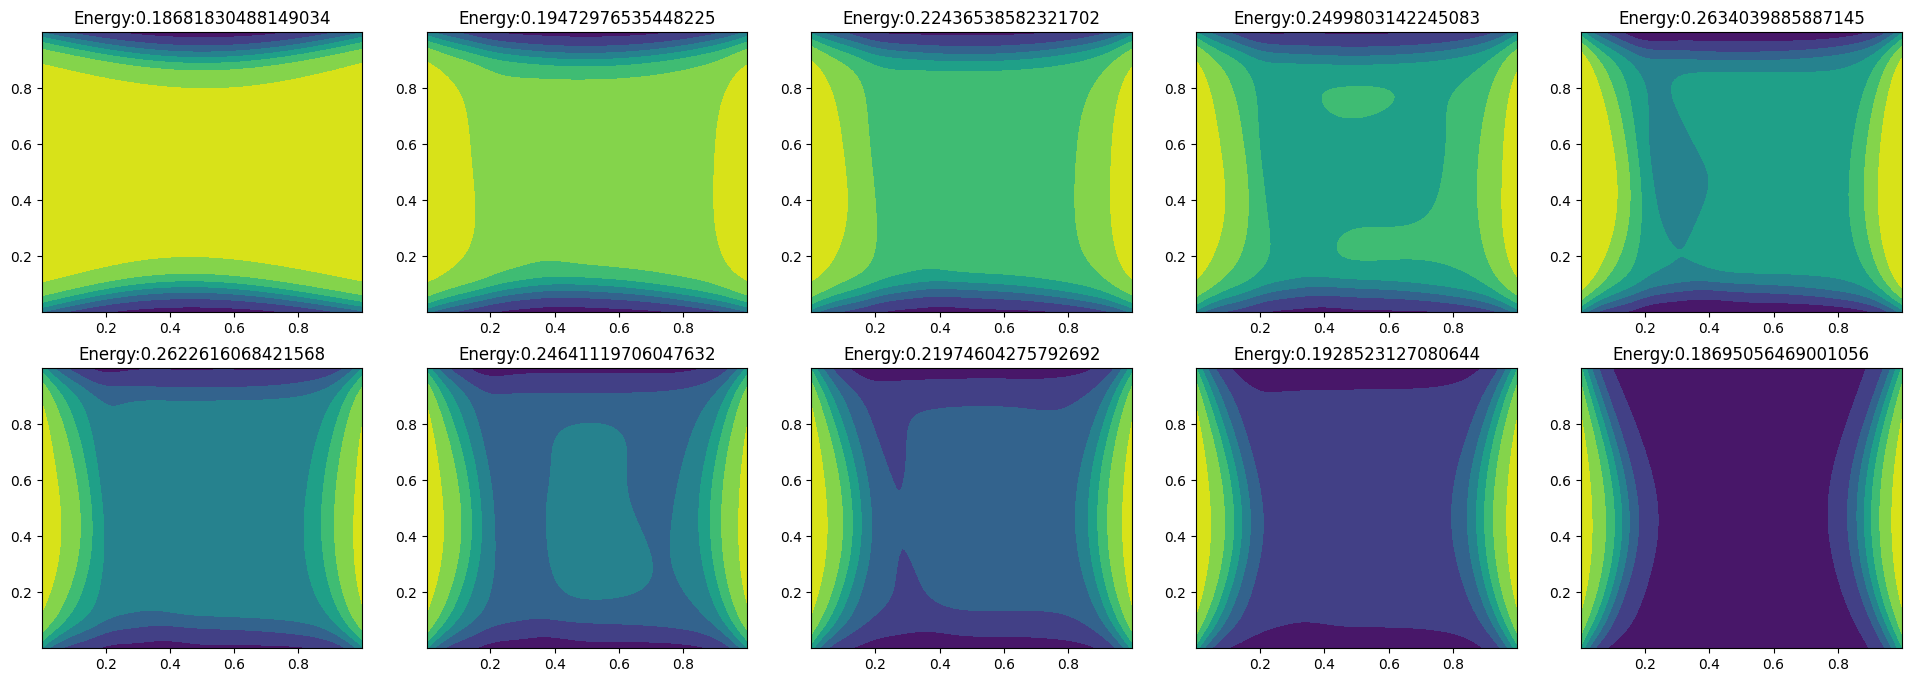

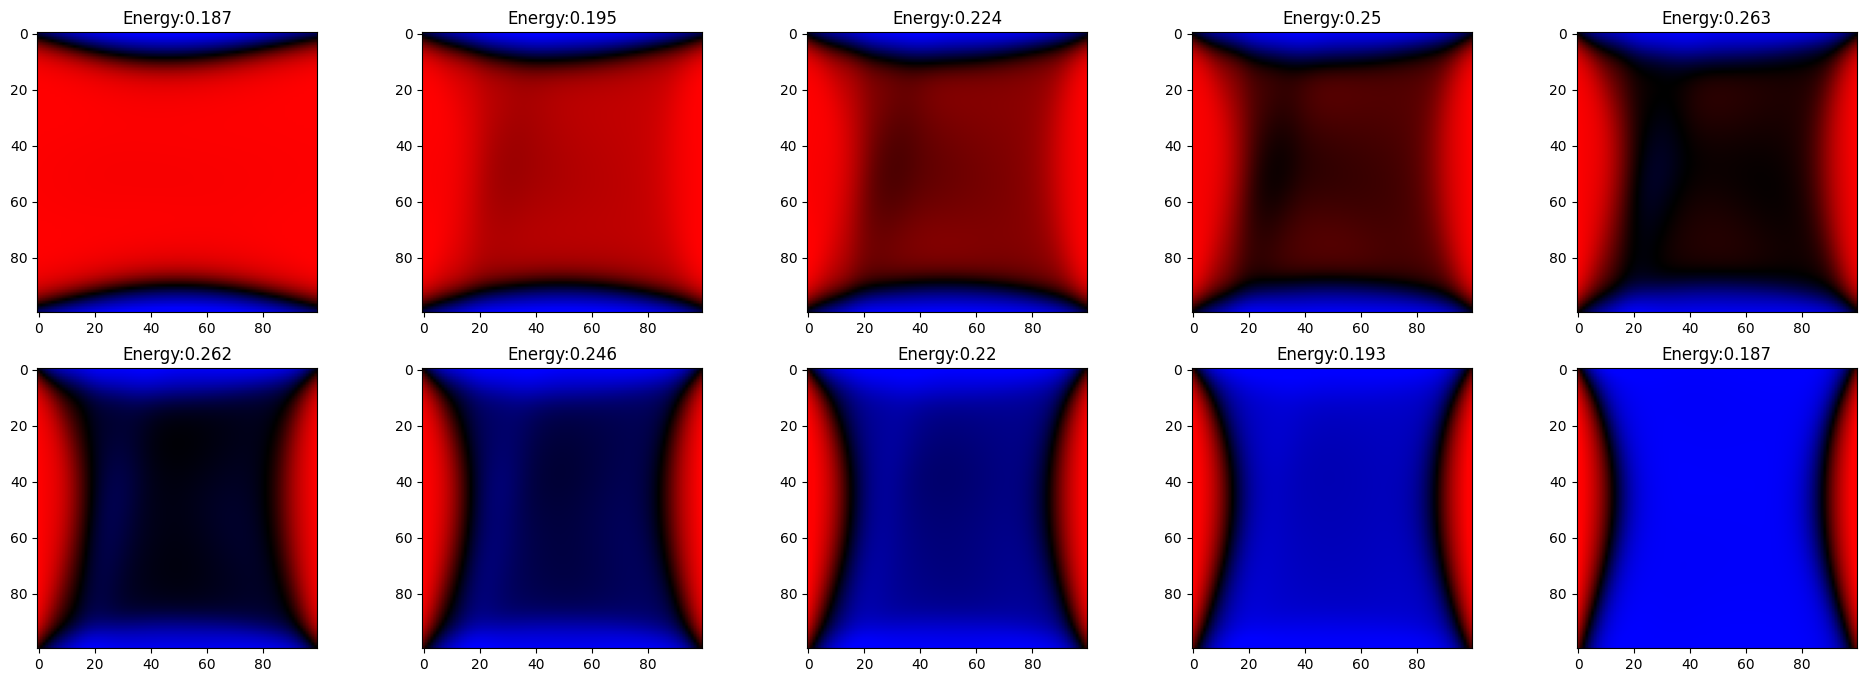

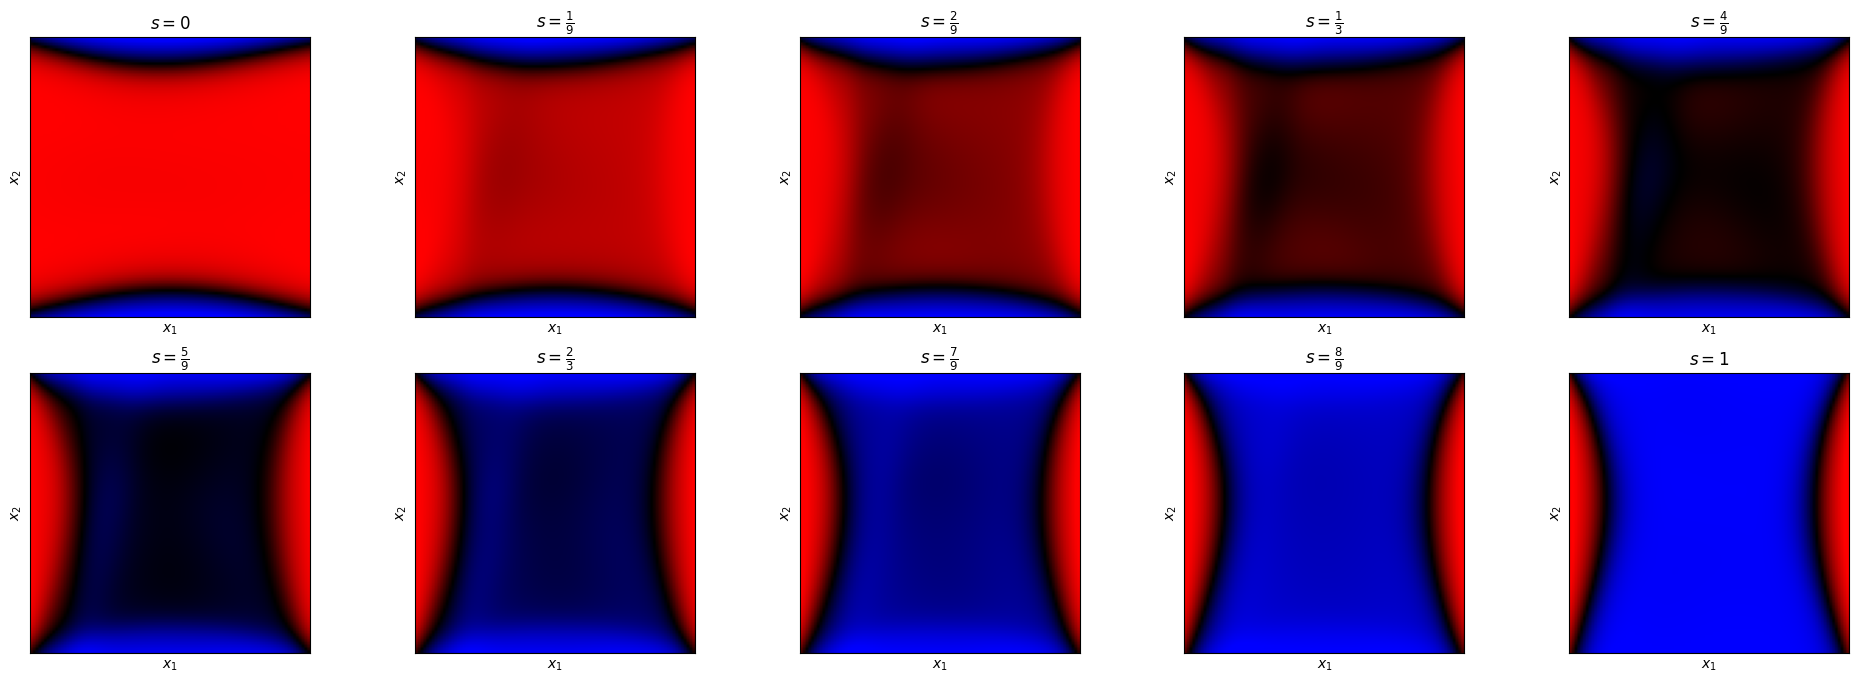

In [ ]:
# This code aims to locatethe MEP by Deep NN method in terms of the extended Muellerpotential

import numpy as np
import torch
import math
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn as nn
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import pickle
from scipy.io import loadmat
import os
import matplotlib.cm as cm


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device to train")


all_path="/content/drive/MyDrive/Colab_Notebooks/2023_mep/0120/"
path_m1="/content/drive/MyDrive/Colab_Notebooks/2023_mep/0120/m3_k005/model_MEP_find_minimals_m3_k005.pth"
path_p1="/content/drive/MyDrive/Colab_Notebooks/2023_mep/0120/p3_k005/model_MEP_find_minimals_p3_k005.pth"


#-------------------------------------------------
# mycase="ac_2d"
# casenum="NBC3_k005_init3_beta10lg_13"

mycase="ac_2d"
casenum="NBC3_k005_init3_lgonly_13"

#path_lmax=all_path+mycase+"_lmax_"+casenum+".pkl"
path_lg=all_path+casenum+"/"+"lgloss"+".pkl"

#-------------------------------------------------
# # True data address

# sol = loadmat(all_path+"true_data11.mat")

# phi_true=sol["phi_n"]

# x_true=np.linspace(0,1,101,endpoint=True)
# t_true=np.linspace(1,0,41,endpoint=True)
# t_true_m,x_true_m=np.meshgrid(t_true,x_true)

# phi_true_all=phi_true.reshape(-1,1)
# t_true_all=t_true_m.reshape(-1,1)
# x_true_all=x_true_m.reshape(-1,1)

#----------------------------------------------


plot_use_all=[]

torch.set_printoptions(precision=10)


model_name= all_path+casenum+"/"+"model_MEP_"+mycase+"_"+casenum+".pth"
model_Parameters_name=model_name


kappa=0.08
load_model = True
batches = 20000 #iterations
beta = 10
learning_rate = 1e-4
dimension = 1 #dimension
dn=100
dnt=28

x_dim=2



alpha1=1 #beta
alpha4=0
alpha3=0.001 # 0.001 for alpha1
alpha5=1 #bound



def mkdir(path):
  folder = os.path.exists(path)
  if not folder:
    os.makedirs(path)
    print("---  new folder...  ---")
    print("---  OK  ---")
  else:
    print("---  There is this folder!  ---")


def fig_loss_batch(plt_batch,loss_batch):
    plt.figure(figsize=(5,4))
    plt.plot(plt_batch,loss_batch,'b-')
    plt.xlabel("Batches")
    plt.ylabel("Loss")

def fig_cos(plt_batch,lg_batch,j):
    fig = plt.figure(figsize=(5,4))
    plt.plot(plt_batch,lg_batch,'b-')
    plt.xlabel("Batches")
    plt.ylabel("$l_g$")
    if j == batches-500:
      plt.savefig(all_path+casenum+"/"+"lgloss"+".jpg")



def fig_countour(xx,phi,ep,j):
    xx1=xx[:,0]
    xx2=xx[:,1]

    xx1=xx1.reshape(dn**2,dnt)
    xx2=xx2.reshape(dn**2,dnt)

    phi_plot_sq=phi.reshape(dn**2,dnt)


    fig1 = plt.figure(figsize=(24,8))
    dn_draw=list(range(0,dnt,int(dnt/9)))

    count=1


    for i in dn_draw:
      fig1.add_subplot(2,5,count)
      plt.contourf(xx1[:,i].reshape(dn,dn),xx2[:,i].reshape(dn,dn),phi_plot_sq[:,i].reshape(dn,dn))
      plt.title("Energy:"+str(ep[i]))
      count=count+1

    fig2 = plt.figure(figsize=(24,8))
    count=1

    for u in dn_draw:
      fig2.add_subplot(2,5,count)
      picori=phi_plot_sq[:,u].reshape(dn,dn)
      pic=np.zeros((dn,dn,3))#rgb

      B=(np.sign(picori)+1)/2*picori # +
      C=(np.sign(picori)-1)/2*picori # -

      # print(B)
      # print(C)


      pic[:,:,0]=B
      pic[:,:,-1]=C

      ee=round(ep[u],3)
      plt.imshow(pic)
      plt.title("Energy:"+str(ee))
      count=count+1

    plt.savefig(all_path+casenum+"/"+str(j)+".pdf")

    fig3 = plt.figure(figsize=(24,8))
    count=1
    #t_all=["0","1/9","2/9","1/3","4/9","5/9","2/3","7/9","8/9","1"]
    t_all=[r"$s=0$",r"$s=\frac{1}{9}$",r"$s=\frac{2}{9}$",r"$s=\frac{1}{3}$",r"$s=\frac{4}{9}$",r"$s=\frac{5}{9}$",r"$s=\frac{2}{3}$",r"$s=\frac{7}{9}$",r"$s=\frac{8}{9}$",r"$s=1$"]

    for u in dn_draw:
      fig3.add_subplot(2,5,count)
      picori=phi_plot_sq[:,u].reshape(dn,dn)
      pic=np.zeros((dn,dn,3))#rgb

      B=(np.sign(picori)+1)/2*picori # +
      C=(np.sign(picori)-1)/2*picori # -

      # print(B)
      # print(C)


      pic[:,:,0]=B
      pic[:,:,-1]=C

      ee=round(ep[u],3)
      #-----------------------------------------
      plt.imshow(pic)
      plt.xticks([])
      plt.yticks([])
      plt.xlabel(r"$x_1$")
      plt.ylabel(r"$x_2$")

      # plt.xlim([0,1])
      # plt.ylim([0,1])

      plt.title(t_all[count-1])
      count=count+1


    #plt.savefig(all_path+casenum+"_energyfig/"+str(j)+"notitle.pdf")
    plt.savefig("dim2_k005_fail.pdf")

class NeuralNetwork_minimum(nn.Module):
    def __init__(self):
        super(NeuralNetwork_minimum, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(2,32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, s):
        phi_pred = self.linear_tanh_stack(s)
        return phi_pred





class NeuralNetwork(nn.Module):
    def __init__(self,p1,m1):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_tanh_stack = nn.Sequential(
            nn.Linear(3,100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 1)
        )
        self.p1=p1
        self.m1=m1


    def forward(self, s):
        x_pred = self.linear_tanh_stack(s)
        ss=s[:,0]
        ss=ss.reshape(-1,1)
        xx=s[:,1:3]

        out=ss*(1-ss)*x_pred + (1-ss)*self.p1(xx) + ss*self.m1(xx)

        return out



def train(model):
    loss_batch=[]
    plt_batch=[]
    lg_batch=[]

    if load_model:

        model.load_state_dict(torch.load(model_Parameters_name))
        #model.load_state_dict(torch.load(model_name))


    ss = np.linspace(0.001,0.999,dnt,endpoint=True)
    x1 = np.linspace(0.001,0.999,dn,endpoint=True)
    x2 = np.linspace(0.001,0.999,dn,endpoint=True)

    xx1,xx2=np.meshgrid(x1,x2)
    xx1=xx1.reshape((-1,1))
    xx2=xx2.reshape((-1,1))

    xx=np.hstack((xx1,xx2))

    xxind=np.linspace(0,dn**2-1,dn**2)

    ss_int_mesh_np,xxind_int_mesh_np=np.meshgrid(ss,xxind)

    ss_int_np=ss_int_mesh_np.reshape((-1,1))
    xxind_np=xxind_int_mesh_np.reshape(-1)

    xx_int_np=xx[xxind_np.astype(np.int32),:]

    ss_int_tensor=Variable(torch.from_numpy(ss_int_np),requires_grad=True).to(device)
    xx_int_tensor1=Variable(torch.from_numpy(xx_int_np),requires_grad=True).to(device)

    xx_all=[]
    for j in range(x_dim):
      xx_all.append(xx_int_tensor1[:,j:j+1])

    xx_int_tensor=torch.cat(xx_all,1)

    ssxx=torch.cat((ss_int_tensor,xx_int_tensor),1)

    phi=model(ssxx)

    gradxx_all=[]
    abs_gradxx_phi_2=0.0
    for j in range(x_dim):
      gradxx_int = torch.autograd.grad(outputs=phi,inputs=xx_all[j],grad_outputs=torch.ones_like(ss_int_tensor),create_graph=True)[0]
      gradxx_all.append(gradxx_int)
      abs_gradxx_phi_2=abs_gradxx_phi_2+gradxx_int**2


    # gradxx2_int=0.0
    # for j in range(x_dim):
    #   gradxx2_j=torch.autograd.grad(outputs=gradxx_all[j],inputs=xx_all[j],grad_outputs=torch.ones_like(ss_int_tensor),create_graph=True)[0]
    #   gradxx2_int=gradxx2_int+gradxx2_j


    # L_phi_mesh_pre=(kappa**2*gradxx2_int-(phi**3-phi))**2
    # L_phi_mesh=L_phi_mesh_pre.reshape((dn**2,dn))#!!!!!!
    # L_int=torch.mean(L_phi_mesh,0)

    # gradss_int = torch.autograd.grad(outputs=phi,inputs=ss_int_tensor,grad_outputs=torch.ones_like(ss_int_tensor),create_graph=True)[0]

    # phi_ss_mesh=gradss_int.reshape((dn**2,dn))

    # phi_int=torch.mean(phi_ss_mesh**2,0)

    # lg=torch.mean(torch.sqrt(L_int)*torch.sqrt(phi_int))

    # lg_batch.append(lg.item())
  #-------------------------------------------------------------


    #---------------------Additional calculation--------------------
    # print(abs_gradxx_phi_2.shape)
    # print(phi.shape)
    # input()
    V_int = kappa**2/2*abs_gradxx_phi_2+(phi**2-1)**2/4

    V_int_mesh=V_int.reshape((dn**2,dnt))
    F_aint=torch.mean(V_int_mesh,0)
    energy_plot=F_aint.cpu().detach().numpy()
    print(energy_plot)

    # print(energy_plot)
    # input()

    #----------------------------------------------------------------

    # Maybe not using the data point to draw figures
    # countor for V
    #fig_cos(plt_batch,lg_batch,i)
    #fig_loss_batch(plt_batch,loss_batch)
    fig_countour(xx_int_np,phi.cpu().detach().numpy(),energy_plot,0)
    plt.show()

    return




if __name__=='__main__':

    net_p1=NeuralNetwork_minimum().to(device)
    net_p1=net_p1.double()
    net_p1.load_state_dict(torch.load(path_p1))

    for p in net_p1.parameters():
        p.requires_grad=False


    net_m1=NeuralNetwork_minimum().to(device)
    net_m1=net_m1.double()
    net_m1.load_state_dict(torch.load(path_m1))


    for p in net_m1.parameters():
        p.requires_grad=False


    mkdir(all_path+casenum+"_energyfig/")


    model = NeuralNetwork(net_p1,net_m1).to(device)
    model = model.double()

    #model = train_pre(model)
    train(model)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')